In [131]:
library(parallel)
library(lme4)
library(mgcv)
library(xtable)

In [132]:
PATH_TO_DATA = '/Users/rachel/Documents/research/hla_ii/clean_matrices/'

Data requirements: patient tissues, patient mutations matrix, patient affinities matrix

In [133]:
get_or <- function(fit) { c(exp(c(coef(fit)[2,1],coef(fit)[2,1]-1.96*coef(fit)[2,2],coef(fit)[2,1]+1.96*coef(fit)[2,2])),coef(fit)[2,4]) }

In [134]:
#Format data
tissue <- read.csv(paste(PATH_TO_DATA, 'patient_tissues.csv', sep=""),header=TRUE)
mut <- read.csv(paste(PATH_TO_DATA, 'patient_mutations.cancer.DR.csv', sep=""),header=TRUE)
aff <- read.csv(paste(PATH_TO_DATA, 'patient_affinities.cancer.DR.csv', sep=""),header=TRUE)
patient <- as.character(mut[,1])
mut <- as.matrix(mut[,-1])
aff <- as.matrix(aff[,-1])
rownames(mut) <- rownames(aff) <- patient

In [135]:
y= as.vector(mut); x= as.vector(aff)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
sel= gene %in% names(nmut[nmut>=5])

In [115]:
head(sel)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

In [23]:
lme1= glmer(y[sel] ~ log(x[sel]) + (1|gene[sel]), family='binomial')
summary(lme1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | gene[sel])

     AIC      BIC   logLik deviance df.resid 
 29386.7  29421.0 -14690.3  29380.7   677982 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2694 -0.0512 -0.0424 -0.0376 27.5751 

Random effects:
 Groups    Name        Variance Std.Dev.
 gene[sel] (Intercept) 0.6316   0.7947  
Number of obs: 677985, groups:  gene[sel], 165

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.17696    0.13225  -46.71   <2e-16 ***
log(x[sel])  0.02427    0.04019    0.60    0.546    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.858

In [21]:
lme2= glmer(y[sel] ~ log(x[sel]) + (1|pat[sel]), family='binomial')
summary(lme2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
 32414.4  32448.7 -16204.2  32408.4   677982 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.0721 -0.0646 -0.0609 -0.0562 29.1612 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 0        0       
Number of obs: 677985, groups:  pat[sel], 4109

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.27115    0.06695  -93.67   <2e-16 ***
log(x[sel])  0.22202    0.02083   10.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.953

In [84]:
mysummarypan <- vector("list",2)
mysummarypan[[1]] <- summary(lme1)
mysummarypan[[2]] <- summary(lme2)
tabgene <- do.call(rbind,lapply(mysummarypan,get_or))
rownames(tabgene) <- c('mutation', 'patient')
colnames(tabgene) <- c('OR', "conf_OR_low", 'conf_OR_high', 'P')
write.table(tabgene, file = "../../../generated_data/pan.txt")

[[1]]
[1] 1.0245638 0.9469510 1.1085379 0.5459853

[[2]]
[1] 1.248598e+00 1.198653e+00 1.300623e+00 1.568396e-26

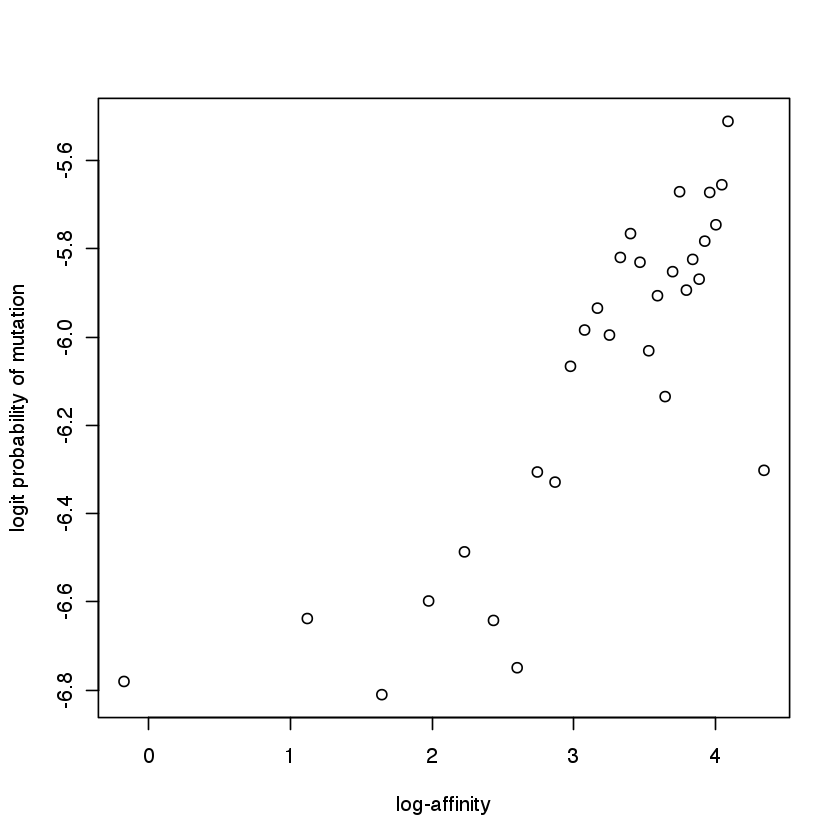

In [155]:
#thre <- c(0,0.5,1,1.5,2,2.5,3,4,5,Inf)
thre <- c(0,2,4,6,8,10,12,14,16,Inf)
xr= cut(x,breaks=thre)
m <- tapply(y,xr,'mean')
thre <- c(seq(0,60,length=30),Inf)
xr= cut(x,breaks=thre)
m <- tapply(y,xr,'mean')
plot(log(tapply(x,xr,'mean')),log(m/(1-m)),xlab='log-affinity',ylab='logit probability of mutation')

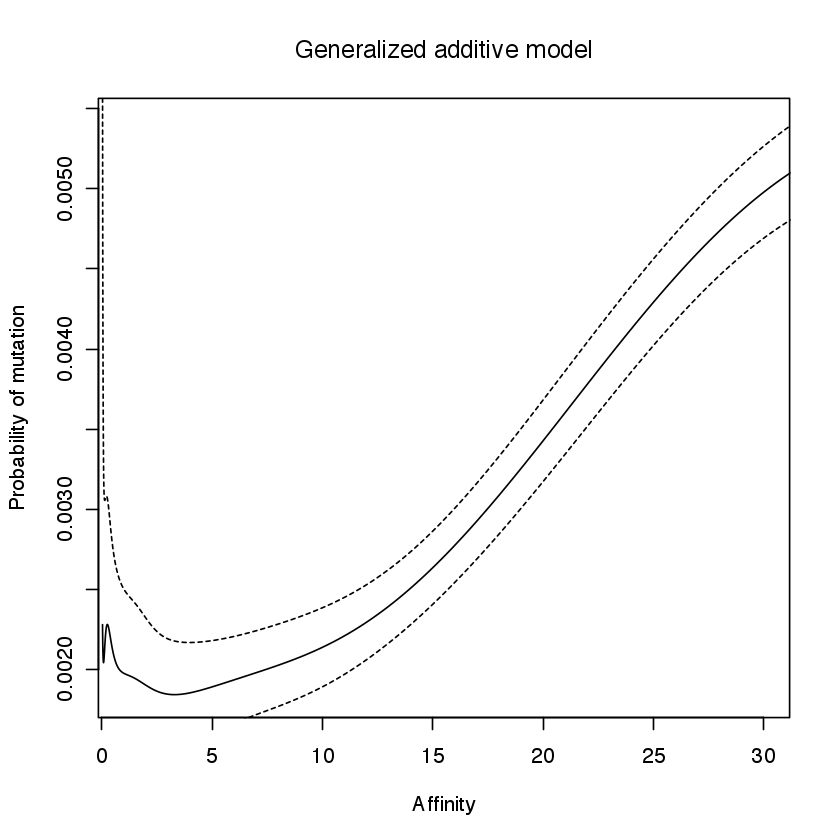

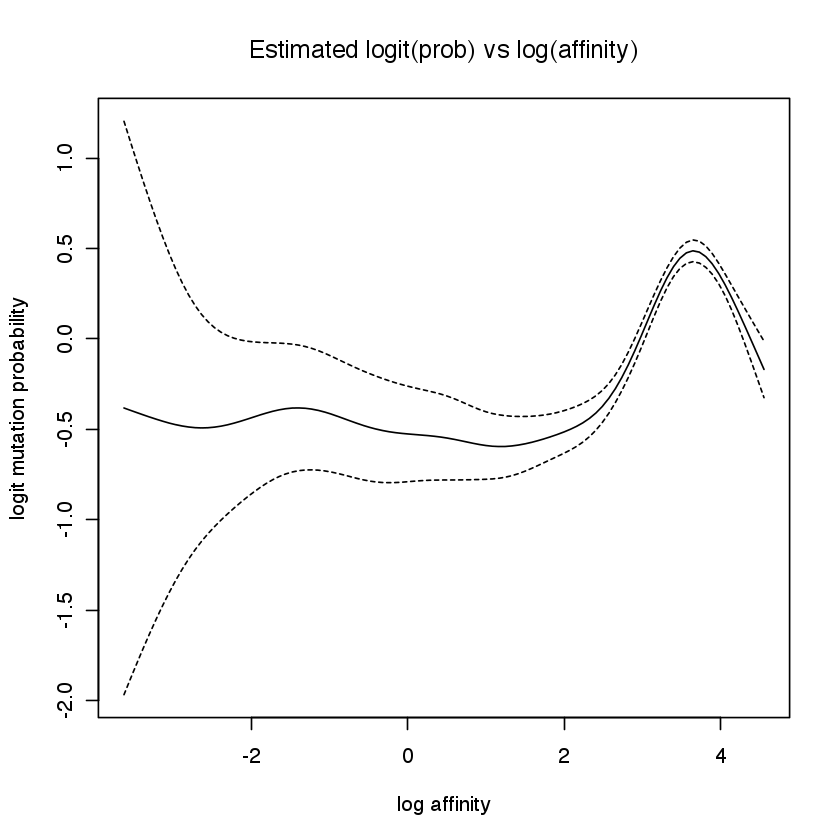

In [128]:
gam1= gam(y[sel] ~ s(log(x[sel])), family='binomial')
ypred= predict(gam1,type='response',se.fit=TRUE)
o= order(x[sel])
plot(x[sel][o],ypred$fit[o],type='l',xlim=c(1,30),xlab='Affinity',ylab='Probability of mutation',main='Generalized additive model')
lines(x[sel][o],ypred$fit[o]-1.96*ypred$se.fit[o],lty=2)
lines(x[sel][o],ypred$fit[o]+1.96*ypred$se.fit[o],lty=2)
#
plot(gam1,rug=FALSE,xlab='log affinity',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

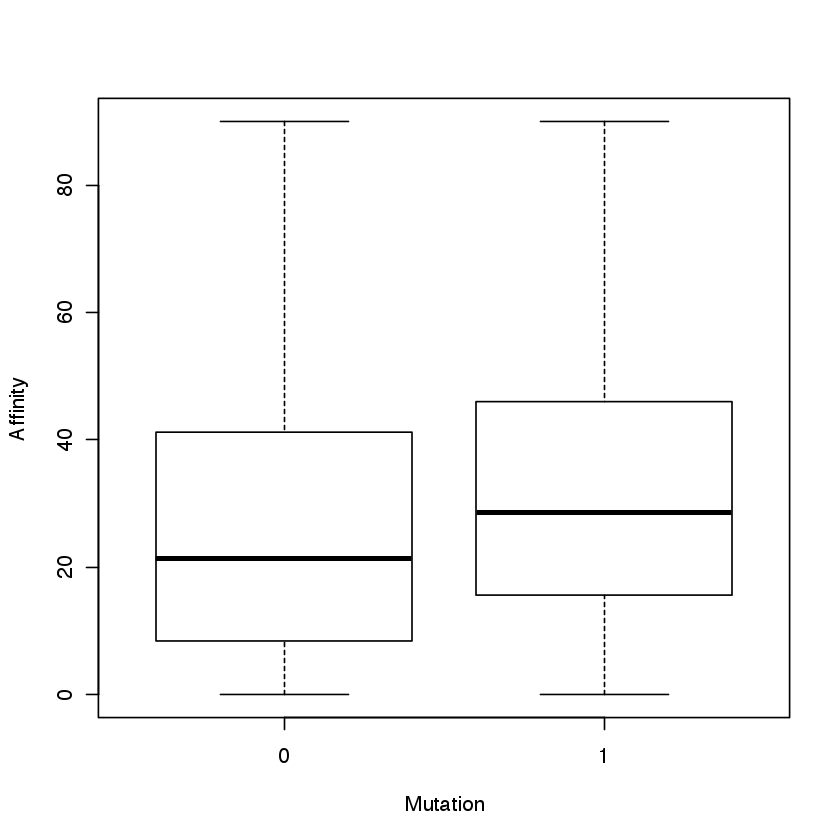

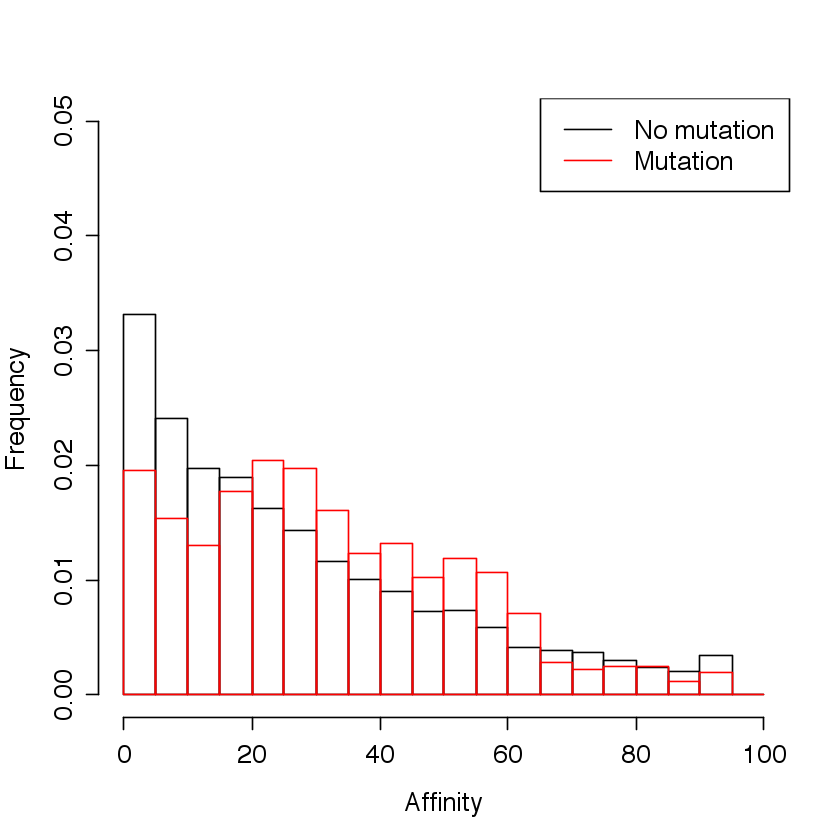

In [120]:
boxplot(x ~ y, outline=F, ylab='Affinity', xlab='Mutation')
#
hist(x[y==0],main='',xlim=c(0,100),ylim=c(0,.05),prob=T,breaks=seq(0,100,by=5),xlab='Affinity',ylab='Frequency',cex.lab=1.3,cex.axis=1.3)
par(new=TRUE)
hist(x[y==1],main='',xlim=c(0,100),ylim=c(0,.05),prob=T,breaks=seq(0,100,by=5),border=2,xaxt='n',yaxt='n',xlab='',ylab='')
legend('topright',c('No mutation','Mutation'),lty=1,col=1:2,cex=1.3)

## Panel D

In [136]:
unique(tissue[,2])

[1] MESO BRCA UCS  LUSC GBM  READ KICH COAD SKCM STAD THCA PRAD CESC BLCA UVM 
[16] ACC  LGG  UCEC TGCT OV   LAML LUAD LIHC HNSC PCPG KIRP SARC DLBC KIRC PAAD
30 Levels: ACC BLCA BRCA CESC COAD DLBC GBM HNSC KICH KIRC KIRP LAML ... UVM

In [137]:
y= as.vector(mut); x= as.vector(aff)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
genesel= (gene %in% names(nmut[nmut>=5]))

In [138]:
#tissuetypes <- as.character(unique(tissue[,2]))
tissuetypes <- c('MESO', 'BRCA', 'UCS')# 'LUSC', 'GBM', 'READ', 'KICH', 'COAD', 'SKCM', 'STAD', 'THCA', 'PRAD', 'CESC', 'BLCA', 'UVM', 'ACC', 'LGG', 'UCEC', 'TGCT', 'OV', 'LAML', 'LUAD', 'LIHC', 'HNSC', 'PCPG', 'KIRP', 'DLBC', 'KIRC', 'PAAD')
mysummary0 <- mysummary1 <- mysummary2 <- vector("list",length(tissuetypes))
names(mysummary0) <- names(mysummary1) <- names(mysummary2) <- tissuetypes
for (i in 1:length(tissuetypes)) {
    message("TISSUE",tissuetypes[i])
    #
    patsel= pat %in% as.character(tissue$Sample[tissue$Tissue==tissuetypes[i]])
    sel= genesel & patsel
    #
    lme0= glm(y[sel] ~ log(x[sel]), family='binomial')
    mysummary0[[i]] <- summary(lme0)
    #
    lme1= glmer(y[sel] ~ log(x[sel]) + (1|gene[sel]), family='binomial')
    mysummary1[[i]] <- summary(lme1)
    #
    lme2= glmer(y[sel] ~ log(x[sel]) + (1|pat[sel]), family='binomial')
    mysummary2[[i]] <- summary(lme2)
    message("Done \n")
}

TISSUEMESO
Done 

TISSUEBRCA
Done 

TISSUEUCS
Done 



In [149]:
tabgene <- do.call(rbind,lapply(mysummary1,get_or))
tabpat <- do.call(rbind,lapply(mysummary2,get_or))
xtable(tabgene[order(rownames(tabgene)),],digits=c(0,3,3,3,4))
xtable(tabpat[order(rownames(tabpat)),],digits=c(0,3,3,3,4))
npat <- table(tissue$Tissue)

,1,2,3,4
BRCA,0.8795808,0.6418547,1.2053544,0.42477714
MESO,5.2594494,0.3629951,76.2043560,0.22358525
UCS,0.7190565,0.5222381,0.9900509,0.04325094


,1,2,3,4
BRCA,0.9192846,0.7821011,1.080531,0.30740995
MESO,5.2594493,0.3625608,76.295632,0.22379257
UCS,0.8167135,0.6580168,1.013684,0.06625308


In [146]:
colnames(tabgene) <- c('OR', "conf_OR_low", 'conf_OR_high', 'P')

In [147]:
tabgene

,OR,conf_OR_low,conf_OR_high,P
MESO,5.2594494,0.3629951,76.2043560,0.22358525
BRCA,0.8795808,0.6418547,1.2053544,0.42477714
UCS,0.7190565,0.5222381,0.9900509,0.04325094


In [150]:
tabpat

MESO,5.2594493,0.3625608,76.295632,0.22379257
BRCA,0.9192846,0.7821011,1.080531,0.30740995
UCS,0.8167135,0.6580168,1.013684,0.06625308


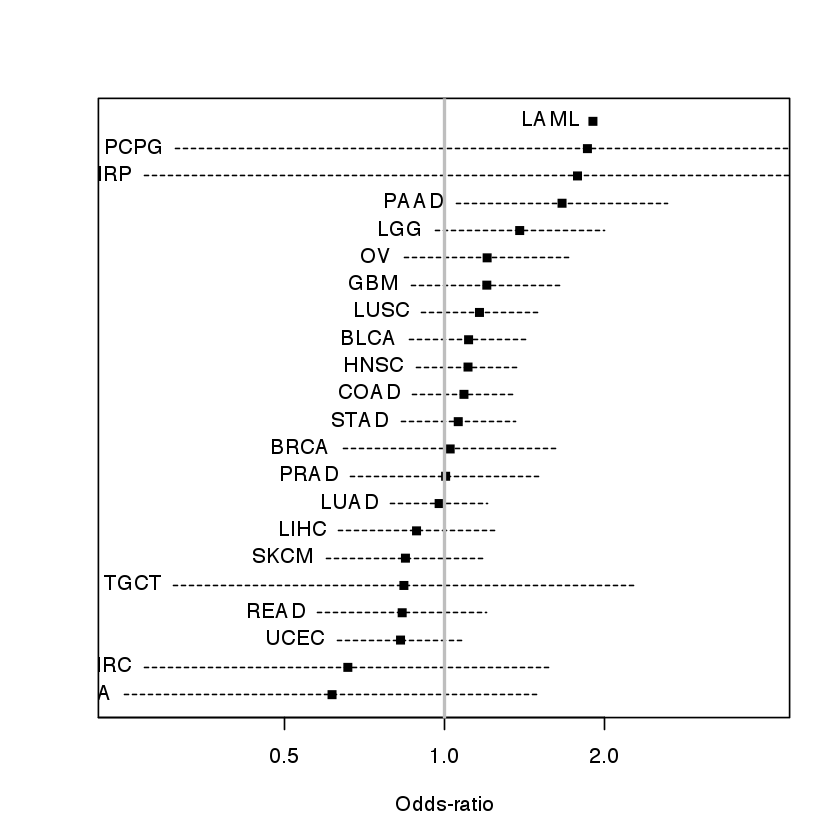

In [52]:
x2plot <- tabgene[order(tabgene[,1]),]
x2plot <- x2plot[rownames(x2plot) %in% names(npat[npat>=100]), ]
plot(x2plot[,1],1:nrow(x2plot),pch=15,xlim=c(0.25,4),yaxt='n',ylab='',xlab='Odds-ratio',log='x')
segments(x0=x2plot[,2],x1=x2plot[,3],1:nrow(x2plot),lty=2)
text(x2plot[,2],1:nrow(x2plot),rownames(x2plot),pos=2)
abline(v=1,col='gray',lwd=2)

## Panel E

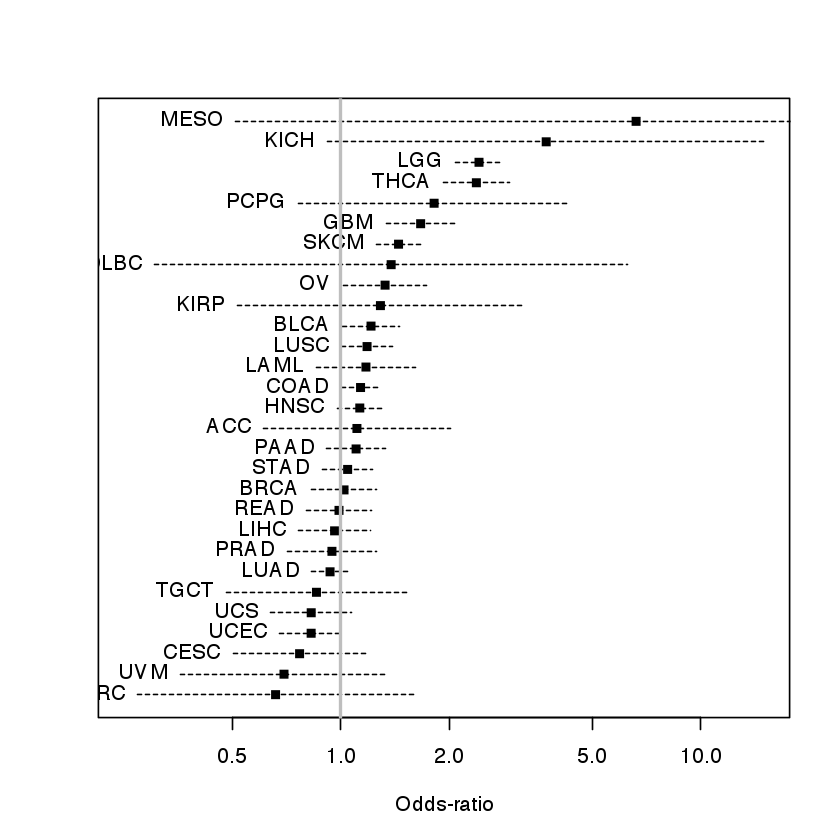

In [53]:
x2plot <- tabpat[order(tabpat[,1]),]
#x2plot <- x2plot[rownames(x2plot) %in% names(npat[npat>=100]), ]

x2plot <- x2plot[rownames(x2plot) %in% names(npat), ]
plot(x2plot[,1],1:nrow(x2plot),pch=15,xlim=c(0.25,15),yaxt='n',ylab='',xlab='Odds-ratio',log='x')
segments(x0=x2plot[,2],x1=x2plot[,3],1:nrow(x2plot),lty=2)
text(x2plot[,2],1:nrow(x2plot),rownames(x2plot),pos=2)
abline(v=1,col='gray',lwd=2)